# Data Skew
- Data skew simple refers to the uneven distribution of data amongst the partitions

## How to Spot Data Skew?
1. If your Spark Job is stuck at one particular stage for a very long time, say for instance it took 10 mins for the job to complete upto 10th Stage but the last stage (11) took around 40 mins to finish then it indicates that one of the partitions had much more data than the others
2. You can check the execution timeline graph for anomalies
3. Or check the summary metrics for the tasks - check if there wide gap with the average time and max execution time

## When does Data Skew happen?1. When joining two large tables with disproportionate matches, in cases where one key in a join matches with a large number of rows from another table. Also possible that: During broadcast joins if the broadcasted data is too large for some partitions
2. 
- In groupBy operations where some keys have many more valartitions

3. itself has skewed data vanatural skew (e.g., geographic data where some regions havemore activity)
- When dealing with time-series data where certain time periods have more events

4. Common rel-world examples:
- Social media data (some users have many more posts than others)
- Transaction data (some products/customers have many more transactions)
- Log data (some events occur much more frequently)
- Geographic data (some regions ha
## Why should we care about Data Skew?
- Data skew leads to uneven utlisation of resources. For instance, if I have 1 executor with 5 cores, and if one partition is taking more time to compute than the others, I would still be paying for all the other cores
- Possibility of getting OOM errors
- Spark might write data to disk - (data spill: when memory buffers fill up, Spark spills to disk) - reading and writing from disk is very expensive and slow
- Excessive garbage collection on heavily loaded executorsany of these scenarios?

In [15]:
import time

In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("data_skew").getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [2]:
# Adaptive Query Execution is enabled by default in Spark
spark.conf.set("spark.sql.adaptive.enabled", False)

In [3]:
# creating a uniform dataset
df_uniform = spark.range(100000)
df_uniform.show(3)

+---+
| id|
+---+
|  0|
|  1|
|  2|
+---+
only showing top 3 rows



In [4]:
# F.spark_partition_id() returns the id of the partition for each row
df_uniform.withColumn("partition", F.spark_partition_id())\
            .groupBy("partition")\
            .count()\
            .orderBy("partition")\
            .show()

+---------+-----+
|partition|count|
+---------+-----+
|        0|12500|
|        1|12500|
|        2|12500|
|        3|12500|
|        4|12500|
|        5|12500|
|        6|12500|
|        7|12500|
+---------+-----+



**same no. of rows in each partition**

In [5]:
# lets create a skewed data set
df0 = spark.range(0, 1000000).repartition(1)
df1 = spark.range(0, 10).repartition(1)
df2 = spark.range(0, 10).repartition(1)
df_skew = df0.union(df1).union(df2)
df_skew.show(3, False)

+---+
|id |
+---+
|0  |
|1  |
|2  |
+---+
only showing top 3 rows



In [6]:
(
    df_skew
    .withColumn("partition", F.spark_partition_id())
    .groupBy("partition")
    .count()
    .orderBy("partition")
    .show()
)

+---------+-------+
|partition|  count|
+---------+-------+
|        0|1000000|
|        1|     10|
|        2|     10|
+---------+-------+



In [7]:
transactions_file = "transactions.parquet"
customer_file = "customers.parquet"

df_transactions = spark.read.parquet(transactions_file)
df_customers = spark.read.parquet(customer_file)

In [8]:
df_transactions.printSchema()
df_transactions.show(5, False)

root
 |-- cust_id: string (nullable = true)
 |-- start_date: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- txn_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- expense_type: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- city: string (nullable = true)

+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
|cust_id   |start_date|end_date  |txn_id         |date      |year|month|day|expense_type |amt   |city       |
+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
|C0YDPQWPBJ|2010-07-01|2018-12-01|TZ5SMKZY9S03OQJ|2018-10-07|2018|10   |7  |Entertainment|10.42 |boston     |
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYIAPPNU066CJ5R|2016-03-27|2016|3    |27 |Motor/Travel |44.34 |portland   |
|C0YDPQWPBJ|2010-07-01|201

In [9]:
df_customers.printSchema()
df_customers.show(5, False)

root
 |-- cust_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthday: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- city: string (nullable = true)

+----------+-------------+---+------+----------+-----+-----------+
|cust_id   |name         |age|gender|birthday  |zip  |city       |
+----------+-------------+---+------+----------+-----+-----------+
|C007YEYTX9|Aaron Abbott |34 |Female|7/13/1991 |97823|boston     |
|C00B971T1J|Aaron Austin |37 |Female|12/16/2004|30332|chicago    |
|C00WRSJF1Q|Aaron Barnes |29 |Female|3/11/1977 |23451|denver     |
|C01AZWQMF3|Aaron Barrett|31 |Male  |7/9/1998  |46613|los_angeles|
|C01BKUFRHA|Aaron Becker |54 |Male  |11/24/1979|40284|san_diego  |
+----------+-------------+---+------+----------+-----+-----------+
only showing top 5 rows



In [11]:
# lets count the number of rows per join key value
(
    df_transactions
    .groupBy("cust_id")
    .agg(F.countDistinct("txn_id").alias("ct"))
    .orderBy(F.desc("ct"))
    .show(5, False)
)

+----------+--------+
|cust_id   |ct      |
+----------+--------+
|C0YDPQWPBJ|17539732|
|C89FCEGPJP|7999    |
|CBW3FMEAU7|7999    |
|C3KUDEN3KO|7999    |
|CHNFNR89ZV|7998    |
+----------+--------+
only showing top 5 rows



**So the customer C0YDPQWPBJ has way more number of transactions than the rest - lets see how that plays out while joining the datasets**

In [12]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [13]:
df_txn_details = (
    df_transactions.join(
        df_customers,
        on="cust_id",
        how="inner"
    )
)

In [16]:
start_time = time.time()
df_txn_details.count()
print(f"time taken: {time.time() - start_time}")

time taken: 34.77151322364807


- If you look at the event timeline you can see that there clearly is an outlier during the join job

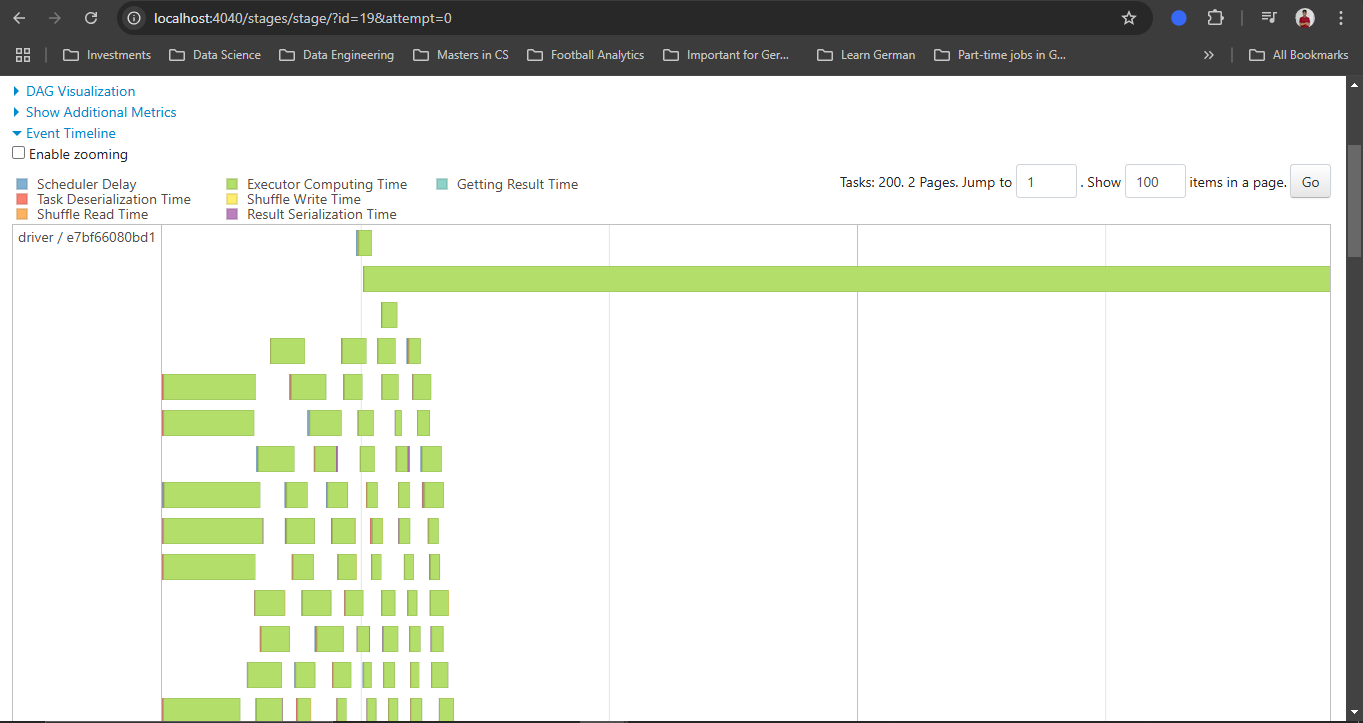

- The Spark UI shows the impact of this skew:
    - The task is spilling 492 MiB to memory
    - Has a disk spill of 3.5 MiB
    - Shows uneven shuffle patterns (3.5 MiB / 17684814 records)
    - The duration shows 20s launch time with 0.4s GC time

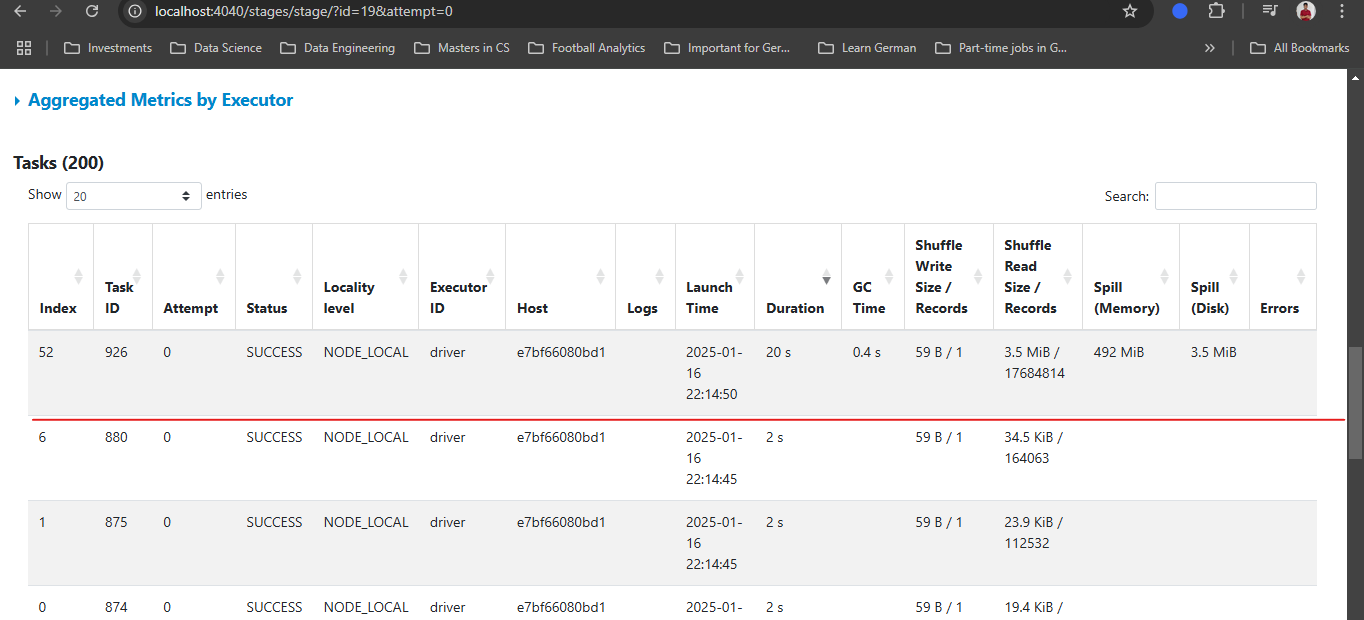